# Computing Selection Coefficients for Length Mutations with Discrete Steps

(c) 2020 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

In [31]:
using Jedi,Plots, Measures, LambertW, CSV, DataFrames, Statistics, LaTeXStrings

Jedi.default_plotlyjs!()

Plots.PlotlyJSBackend()

Set fitness parameters.

In [33]:
N = 1000
f0 = 50/2N
fl = 0.3/2N
F = Jedi.fermi_fitness(f0=f0, fl=fl)

fermi_fitness(10, 1.0, 0.025, 0.00015, Jedi.Est)

Use function to compute predicted mutation selection balance

In [34]:
function theoretical_msb(rho, l::Array{Int64, 1}=collect(8:40))
    Z = lambertw.(3/4 * N * f0 * l * exp(10)/(1+rho)) ./2
    k_msb = -Z .+ (l .* (3/4))
    return k_msb
end

theoretical_msb (generic function with 2 methods)

First let's look at the predicted genetic load at equilibrium for given binding site length.

In [35]:
l = collect(8:40)
k = theoretical_msb(0, l)

plot(8:40, f0 .- fitness.(k*2, l, F), xlabel="l", ylabel="Load", linewidth=2)

<!DOCTYPE html>
 
 
 Plots.jl

Here we can clearly see how the load is minimal for $l=10$ for these parameters. However, this calculation does not consider the asymmetry of length mutations, which come from the fact that when adding a position, the position is random compared to the optimal letter at that position. When removing a position, it is likely to hit an adapated site, whose removal comes with a negative effect to the binding site.

In [6]:
l = collect(8:40)
delta = 1
k = theoretical_msb(0, l)
s_plus_match = fitness.(k*2, l.+1, F) .- fitness.(k.*2, l, F)
s_plus_mismatch = fitness.((k .+ delta)*2, l.+1, F) .- fitness.(k.*2, l, F)


k = theoretical_msb(0, l.+1)
s_minus_match = fitness.(k*2, l, F) .- fitness.(k.*2, l.+1, F)
s_minus_mismatch = fitness.((k .- delta)*2, l, F) .- fitness.(k.*2, l.+1, F)


plot(
    8:40, 
    ((1/4 .* s_plus_match) .+ (3/4 .* s_plus_mismatch)) * N, 
    label="Increase",
    ylabel="Ns",
    xlabel="l",
    linewidth=2,
    title="Selection Coefficients for Length Mutations",
    top_margin=4mm
)

plot!(
    8:40, 
    ((k ./ (l.+1) .* s_minus_mismatch) .+ ((1 .- k ./ (l.+1)) .* s_minus_match)) * N, 
    label="Decrease",
    linewidth=2,
)

<!DOCTYPE html>
 
 
 Plots.jl

Here we can clearly see that for these parameters, length decrease mutations are much more deleterious than length increase mutations. Also interesting is that both types of mutations are deleterious. However, this should still lead to a lenght increase, since these mutations are less deleterious. Followed by a length mutation is an adaptation period, since length mutations are assumed to be rare. Thus, we can look at the fitness gain/loss that occurs due to the relaxation to steady state at the current binding site length.

We can try increasing the fitness cost for binding length, which should put length decrease mutations at more of an advantage.

In [7]:
F.fl = 1/2N

l = collect(8:40)

k = theoretical_msb(0, l)
s_plus_match = fitness.(k*2, l.+1, F) .- fitness.(k.*2, l, F)
s_plus_mismatch = fitness.((k .+ 1)*2, l.+1, F) .- fitness.(k.*2, l, F)


k = theoretical_msb(0, l.+1)
s_minus_match = fitness.(k*2, l, F) .- fitness.(k.*2, l.+1, F)
s_minus_mismatch = fitness.((k .- 1)*2, l, F) .- fitness.(k.*2, l.+1, F)


plot(
    8:40, 
    ((1/4 .* s_plus_match) .+ (3/4 .* s_plus_mismatch)) * N, 
    label="Increase",
    ylabel="Ns",
    xlabel="l",
    linewidth=2,
    title="Selection Coefficients for Length Mutations",
    top_margin=4mm
)

plot!(
    8:40, 
    ((k ./ (l.+1) .* s_minus_mismatch) .+ ((1 .- k ./ (l.+1)) .* s_minus_match)) * N, 
    label="Decrease",
    linewidth=2,
)

<!DOCTYPE html>
 
 
 Plots.jl

Here we can see that there is a length where the length increase and decrease mutations have an intersection. From the selection coefficients we can compute substitution rates for increase and decrease mutations.

In [8]:
function length_rates(rho::Real, l::Array{Int, 1}=collect(8:40))
    k = theoretical_msb(rho, l.+1)
    
    s_plus_match = fitness.(k*2, l.+1, F) .- fitness.(k.*2, l, F)
    s_plus_mismatch = fitness.((k .+ 1)*2, l.+1, F) .- fitness.(k.*2, l, F)


    k = theoretical_msb(rho, l.+1)
    s_minus_match = fitness.(k*2, l, F) .- fitness.(k.*2, l.+1, F)
    s_minus_mismatch = fitness.((k .- 1)*2, l, F) .- fitness.(k.*2, l.+1, F)
    
    up = kimura_prob.(((1/4 .* s_plus_match) .+ (3/4 .* s_plus_mismatch)), N)
    down = kimura_prob.(((k ./ (l.+1) .* s_minus_mismatch) .+ ((1 .- k ./ (l.+1)) .* s_minus_match)), N)
    return up, down
end


length_rates (generic function with 2 methods)

From the rates, we can compute a marginal length distribution, assuming detailed balance, which we can do due to the separation of time scales. Let's first look at the distribution for the initial fitness cost for length.

In [9]:
F.fl = 0.25/2N
up, down = length_rates(0)
p_l = zeros(length(up))
p_l[1] = 0.1

# detailed balance
for i in 2:length(up)
    p_l[i] = p_l[i-1] * up[i-1] / down[i]
end

# normalize
p_l /= sum(p_l)

plot(8:40, p_l, xlabel="l", ylabel="p(l)", linewidth=2, label="ρ=0")

<!DOCTYPE html>
 
 
 Plots.jl

We see that the distribution is peaked around values much higher than the predicted length from the genetic load observation, which was around $l=10$ for these values. Let's have a look at how this distribution behaves with increased non-equilibrium.

In [10]:
F.fl = 0.3/2N
p_left = plot(xlabel="l", ylabel="p(l)")
p_right = plot(xlabel="ρ", ylabel="l_opt")
for rho in [0, 0.1, 0.5, 1]
    up, down = length_rates(rho)
    p_l = zeros(length(up))
    p_l[1] = 0.1

    # detailed balance
    for i in 2:length(up)
        p_l[i] = p_l[i-1] * up[i-1] / down[i]
    end

    # normalize
    p_l /= sum(p_l)
    scatter!(p_right, [rho], [argmax(p_l) + 7])
    plot!(p_left, 8:40, p_l, linewidth=2, label="ρ=$rho")
end
plot(p_left, p_right, size=(700, 400),legend=:none)

<!DOCTYPE html>
 
 
 Plots.jl

In [11]:
l_opt = []
for rho in 0:0.01:2
    up, down = length_rates(rho, collect(8:60))
    p_l = zeros(length(up))
    p_l[1] = 0.1

    # detailed balance
    for i in 2:length(up)
        p_l[i] = p_l[i-1] * up[i-1] / down[i]
    end

    # normalize
    p_l /= sum(p_l)
    push!(l_opt, argmax(p_l) + 7)
end
plot(0:0.01:2, l_opt, xlabel="ρ", ylabel="l_opt")

<!DOCTYPE html>
 
 
 Plots.jl

Let's compare this with the result from looking at the minimal load.

In [12]:
x = Any[9.241341851482083, 9.283634505008324, 9.325703054538993, 9.367550833504138, 9.409181094303246, 9.450597011025444, 9.491801682053627, 9.532798132558572, 9.573589316888581, 9.614178120860002, 9.654567363953568, 9.694759801421252, 9.734758126308062, 9.774564971392884, 9.814182911052347, 9.853614463051382, 9.892862090263948, 9.931928202327255, 9.97081515723255, 10.009525262855473, 10.048060778428685, 10.086423915959468, 10.124616841594756, 10.162641676935957, 10.20050050030581, 10.238195347969393, 10.275728215311302, 10.313101057970865, 10.350315792937263, 10.387374299606227, 10.424278420799972, 10.461029963751878, 10.497630701057457, 10.534082371592925, 10.570386681402809, 10.606545304557748, 10.642559883983804, 10.67843203226434, 10.714163332415646, 10.749755338637272, 10.785209577038145, 10.820527546339358, 10.855710718554576, 10.8907605396489, 10.925678430177033, 10.960465785901528, 10.995123978391865, 11.029654355605086, 11.06405824244869, 11.098336941326405, 11.13249173266751, 11.166523875440292, 11.200434607650203, 11.234225146823292, 11.267896690475414, 11.30145041656777, 11.334887483949176, 11.368209032785645, 11.401416184977597, 11.43451004456526, 11.467491698122535, 11.500362215139845, 11.533122648396239, 11.565774034321203, 11.598317393346452, 11.630753730248099, 11.663084034479455, 11.695309280494856, 11.727430428064723, 11.759448422582205, 11.791364195361654, 11.823178663929182, 11.854892732305595, 11.886507291281898, 11.918023218687662, 11.94944137965241, 11.980762626860313, 12.011987800798357, 12.043117729998194, 12.07415323127188, 12.105095109941693, 12.135944160064184, 12.16670116464867, 12.197366895870303, 12.22794211527793, 12.258427573996816, 12.288824012926488, 12.319132162933736, 12.349352745041006, 12.37948647061025, 12.409534041522422, 12.439496150352696, 12.469373480541563, 12.499166706561907, 12.528876494082194, 12.558503500125854, 12.588048373226995, 12.617511753582528, 12.646894273200827, 12.676196556046982, 12.705419218184787, 12.73456286791552, 12.763628105913604, 12.792615525359258, 12.821525712068185, 12.850359244618419, 12.87911669447435, 12.907798626108065, 12.936405597118037, 12.964938158345245, 12.993396853986772, 13.021782221706992, 13.05009479274637, 13.078335092027936, 13.106503638261534, 13.134600944045841, 13.162627515968271, 13.190583854702792, 13.218470455105702, 13.246287806309427, 13.274036391814388, 13.30171668957899, 13.329329172107771, 13.35687430653776, 13.384352554723081, 13.411764373317885, 13.439110213857575, 13.466390522838442, 13.493605741795713, 13.520756307380049, 13.547842651432541, 13.574865201058227, 13.601824378698188, 13.628720602200243, 13.655554284888247, 13.682325835630095, 13.70903565890438, 13.735684154865817, 13.762271719409387, 13.788798744233288, 13.815265616900685, 13.841672720900299, 13.868020435705883, 13.894309136834565, 13.920539195904103, 13.946710980689113, 13.97282485517624, 13.998881179618312, 14.024880310587518, 14.05082260102761, 14.07670840030517, 14.102538054259943, 14.128311905254252, 14.154030292221563, 14.179693550714155, 14.205302012949945, 14.230856007858504, 14.256355861126236, 14.281801895240788, 14.307194429534661, 14.332533780228083, 14.357820260471117, 14.383054180385052, 14.408235847103086, 14.4333655648103, 14.458443634782956, 14.483470355427107, 14.508446022316598, 14.533370928230362, 14.558245363189144, 14.583069614491567, 14.60784396674963, 14.632568701923582, 14.65724409935624, 14.681870435806728, 14.706447985483674, 14.730977020077846, 14.755457808794256, 14.77989061838375, 14.804275713174084, 14.828613355100487, 14.852903803735744, 14.87714731631978, 14.901344147788793, 14.925494550803895, 14.949598775779322, 14.973657070910182, 14.997669682199769, 15.021636853486452, 15.045558826470135, 15.069435840738304, 15.093268133791678, 15.117055941069452, 15.140799495974152, 15.164499029896112, 15.188154772237558, 15.211766950436354, 15.235335789989362, 15.258861514475445, 15.28234434557813]
plot!(0.01:0.01:2, x)

<!DOCTYPE html>
 
 
 Plots.jl

We see that there is a clear deviation betweem these results, leading to the assumtpion that the asymmetry of length mutations has a non-negligible effect. This could be proof of a "Ratchet", which further increases binding site lengths. Let's look at the ratio of these two.  

In [13]:
plot(0.01:0.01:2, l_opt[2:end] ./ x)

<!DOCTYPE html>
 
 
 Plots.jl

In [14]:
(2.7*2^2)

10.8

There seems to be a small increase in the ratio, but the increase of this ratio seems to be negligible.

And now with a higher length cost.

In [15]:
F.fl = 1.8/2N

l_opt = []
for rho in 0:0.01:2
    up, down = length_rates(rho, collect(8:60))
    p_l = zeros(length(up))
    p_l[1] = 0.1

    # detailed balance
    for i in 2:length(up)
        p_l[i] = p_l[i-1] * up[i-1] / down[i]
    end

    # normalize
    p_l /= sum(p_l)
    push!(l_opt, argmax(p_l) + 7)
end
plot(0:0.01:2, l_opt, xlabel="ρ", ylabel="l_opt")

<!DOCTYPE html>
 
 
 Plots.jl

Let's compare this to the load prediction that we made in another notebook (The array below is simply copied from there).

In [16]:
plot!(0.01:0.01:2, x)

<!DOCTYPE html>
 
 
 Plots.jl

This looks great.

Now we can reconstruct the join probabiliy $Q(\Gamma,l)$ by multiplying the marginal length distribution to the conditional distrbution for binding energies at given lengths.

In [17]:
function fixed_l_Q(rho, F, l_arr::Array{Int, 1}=collect(8:40))
    Q_k = zeros(Float64, length(l_arr), 101)
    for (j, l_0) in enumerate(l_arr)
        F.l = l_0
        for (i, g) in enumerate(0:0.01:1)
            Q_k[j, i] = exp(-1/2*(l_0 * (g-3/4))^2/(3*l_0/16)) * exp(2N/(1+rho)*fitness(2l_0*g, F))
        end
    end
    return Q_k
end

fixed_l_Q (generic function with 2 methods)

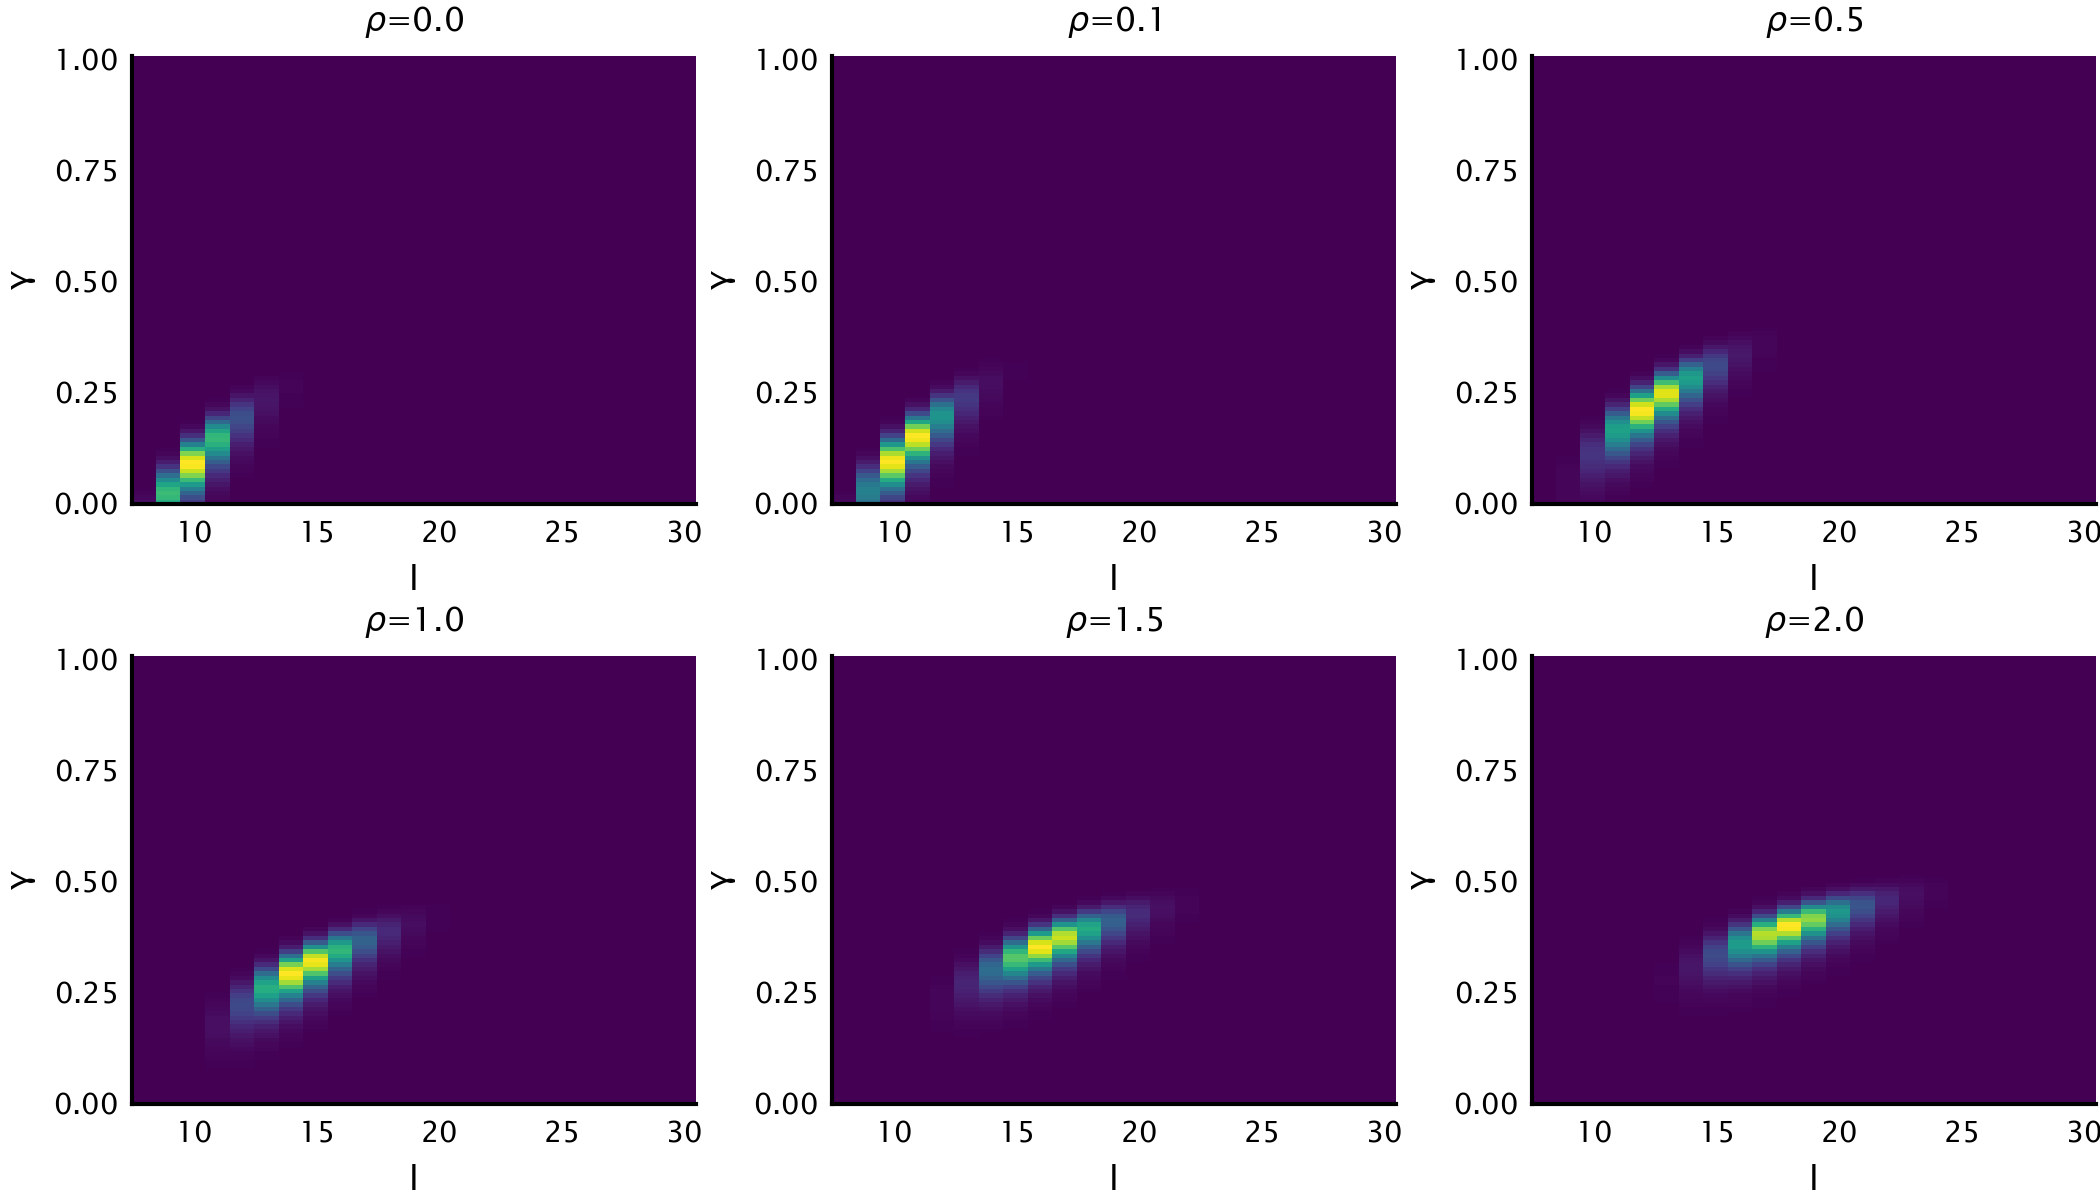

In [18]:
function twoDQ(rho, F, l_arr::Array{Int, 1}=collect(8:40))
    Q = fixed_l_Q(rho, F, l_arr)
    
    up, down = length_rates(rho, l_arr)
    
    p_l = zeros(length(up))
    p_l[1] = 0.1

    # detailed balance
    for i in 2:length(up)
        p_l[i] = p_l[i-1] * up[i-1] / down[i]
    end

    # normalize
    p_l /= sum(p_l)
    Q_l = Q .* p_l
    p1 = heatmap(
        l_arr, 
        0:0.01:1, 
        Q_l', 
        color=:viridis, 
        title=L"$\rho$="*"$rho", 
        colorbar=false, 
        #top_margin=6mm, 
        xlabel="l", 
        ylabel="γ", 
        #bottom_margin=10mm,
        #left_margin=5mm,
        #right_margin=5mm,
        titlefontsize=8
    )
    return p1
end

default_pyplot!()
plot([twoDQ(rho, F, collect(8:30)) for rho in [0, 0.1, 0.5, 1, 1.5, 2]]..., layout=(2,3), size=(700, 400), link=:all)
#twoDQ(0, F)

In [19]:
savefig("../figures/moving_dist_discrete.pdf")

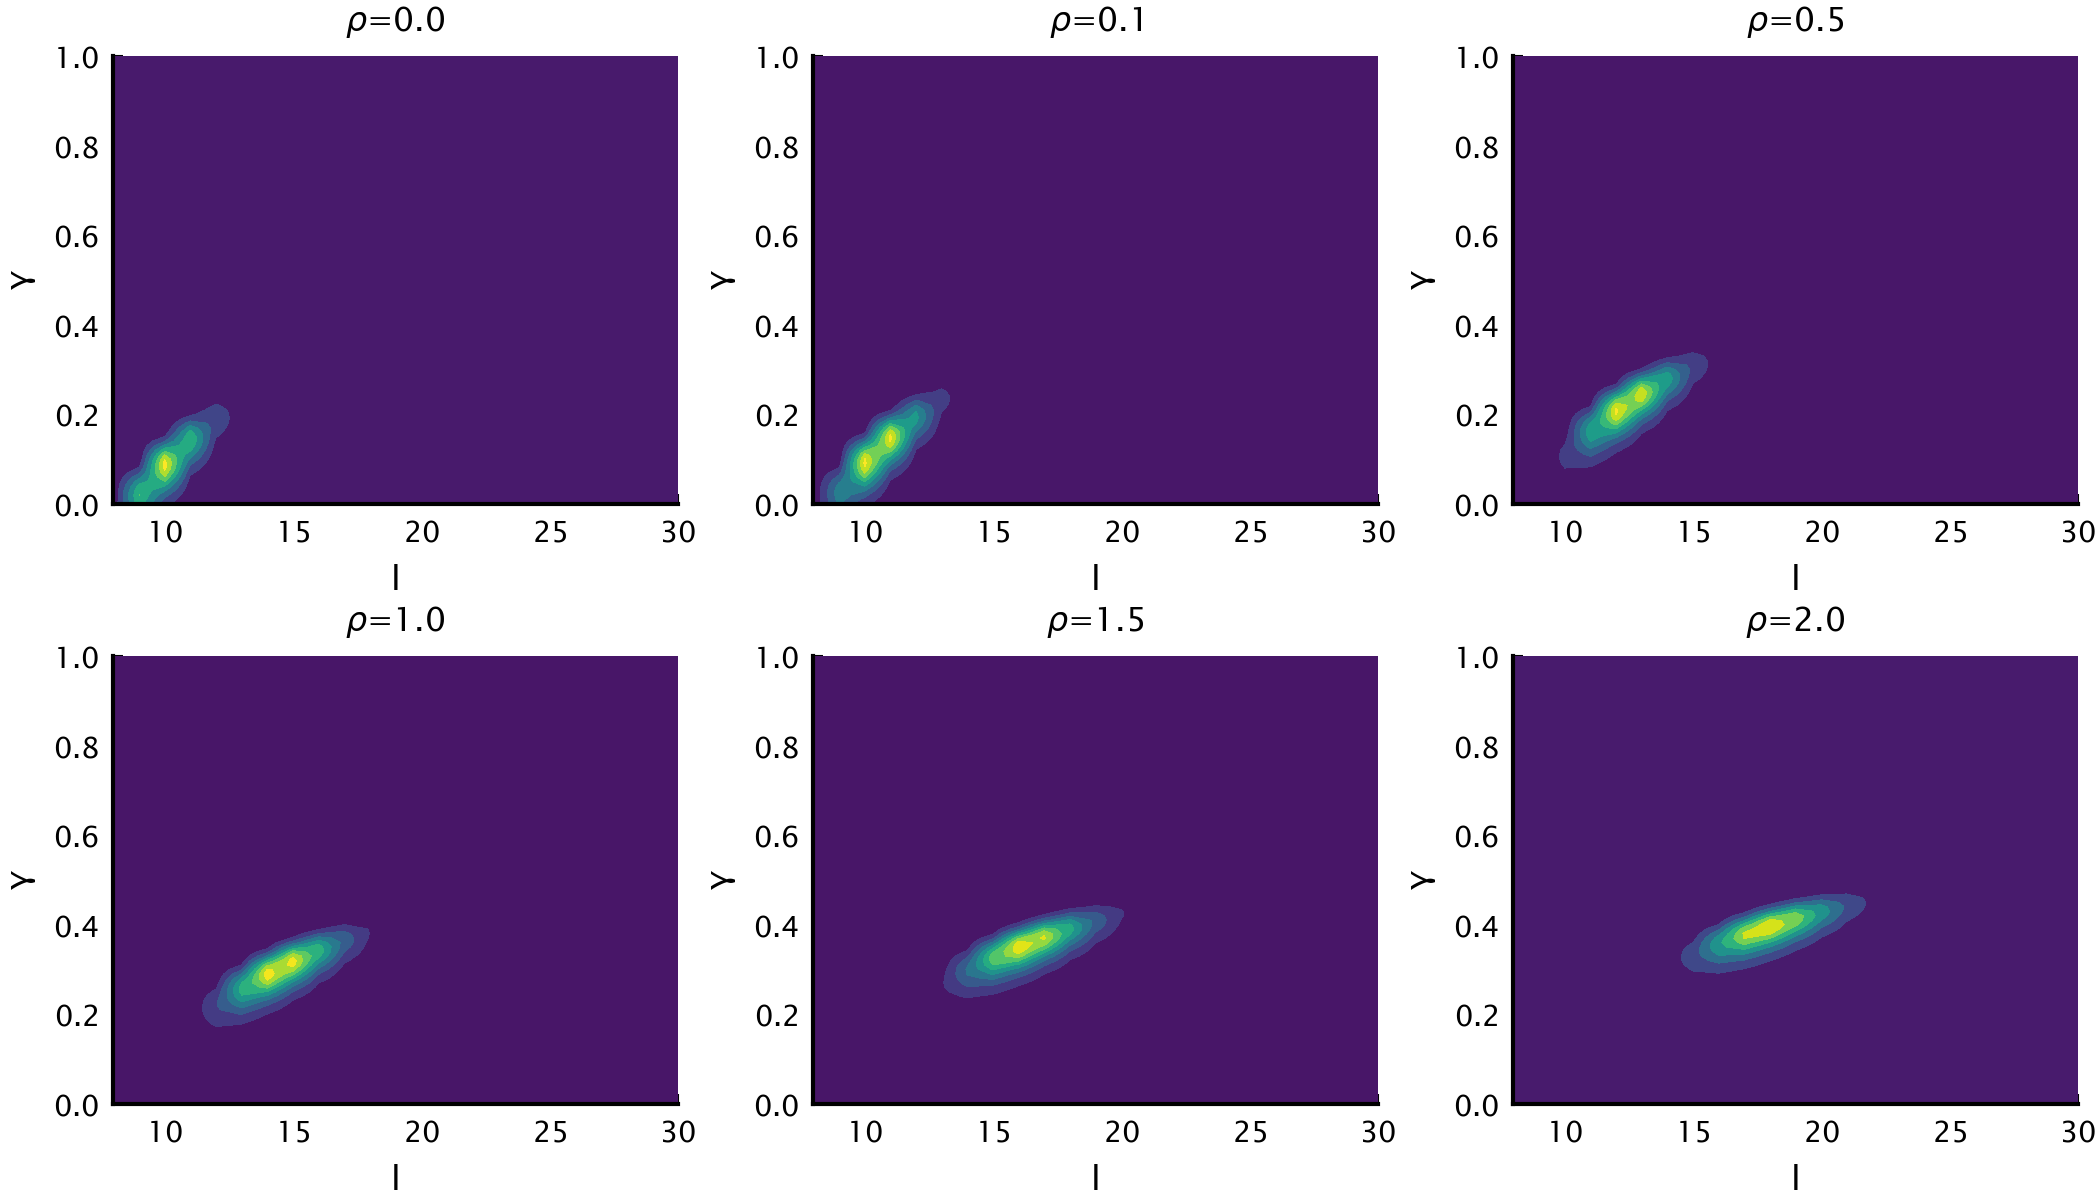

In [20]:
function twoDQ(rho, F, l_arr::Array{Int, 1}=collect(8:40))
    Q = fixed_l_Q(rho, F, l_arr)
    
    up, down = length_rates(rho, l_arr)
    
    p_l = zeros(length(up))
    p_l[1] = 0.1

    # detailed balance
    for i in 2:length(up)
        p_l[i] = p_l[i-1] * up[i-1] / down[i]
    end

    # normalize
    p_l /= sum(p_l)
    Q_l = Q .* p_l
    p1 = contourf(
        l_arr, 
        0:0.01:1, 
        Q_l', 
        color=:viridis, 
        title=L"$\rho$="*"$rho", 
        colorbar=false, 
        #top_margin=6mm, 
        xlabel="l", 
        ylabel="γ", 
        #bottom_margin=10mm,
        #left_margin=5mm,
        #right_margin=5mm,
        titlefontsize=8,
        levels=8
    )
    return p1
end

default_pyplot!()
plot([twoDQ(rho, F, collect(8:30)) for rho in [0, 0.1, 0.5, 1, 1.5, 2]]..., layout=(2,3), size=(700, 400), link=:all)

In [21]:
savefig("../figures/moving_dist_contour.pdf")

## Data

In [22]:
df = CSV.read("../outputs/2020_09_03_script4_results.csv")

,rho,l,Gamma
,Float64,Float64,Float64
1,0.0,15.0,6.0
2,0.0,14.0,4.0
3,0.0,14.0,8.0
4,0.0,14.0,6.0
5,0.0,14.0,8.0
6,0.0,14.0,4.0
7,0.0,14.0,8.0
8,0.0,14.0,8.0
9,0.0,13.0,4.0


In [23]:
df_ends = df[1000:1000:end, :]


,rho,l,Gamma
,Float64,Float64,Float64
1,0.0,15.0,8.0
2,0.0,22.0,18.0
3,0.0,28.0,28.0
4,0.0,17.0,12.0
5,0.0,19.0,14.0
6,0.0,12.0,4.0
7,0.0,34.0,36.0
8,0.0,18.0,12.0
9,0.0,28.0,26.0


In [24]:
gdf = groupby(df_ends, :rho)
cdf_means = combine([:l, :Gamma] => (x, y) -> (mean_l=mean(x), mean_gamma=mean(y)), gdf)

,rho,mean_l,mean_gamma
,Float64,Float64,Float64
1,0.0,20.385,15.89
2,0.1,20.035,15.51
3,0.5,21.24,17.8
4,1.0,23.095,21.63
5,2.0,23.405,24.47


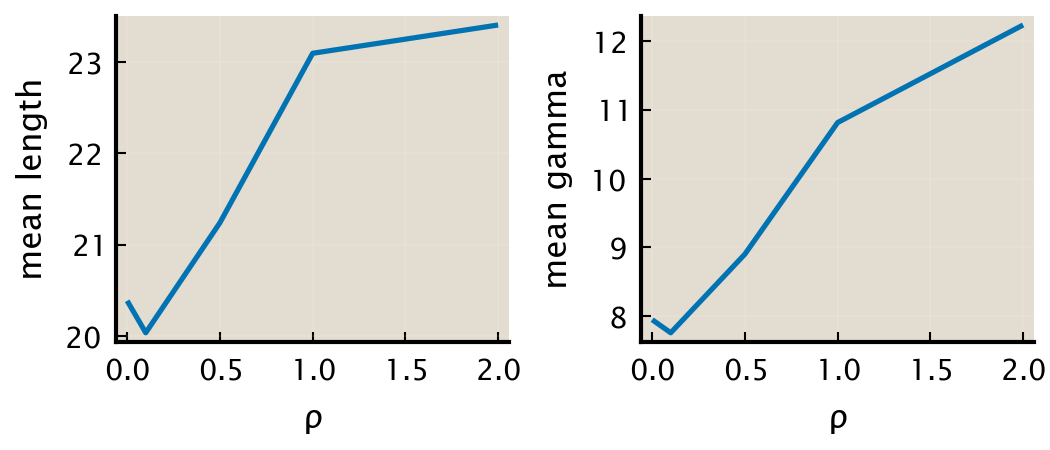

In [25]:
plot(
    plot(
        cdf_means.rho, 
        cdf_means.mean_l, 
        xlabel="ρ", 
        ylabel="mean length"
        ), 
    plot(
        cdf_means.rho, 
        cdf_means.mean_gamma./2,
        xlabel="ρ",
        ylabel="mean gamma",
    ),
    size=(350, 150),
    margin=4mm
)

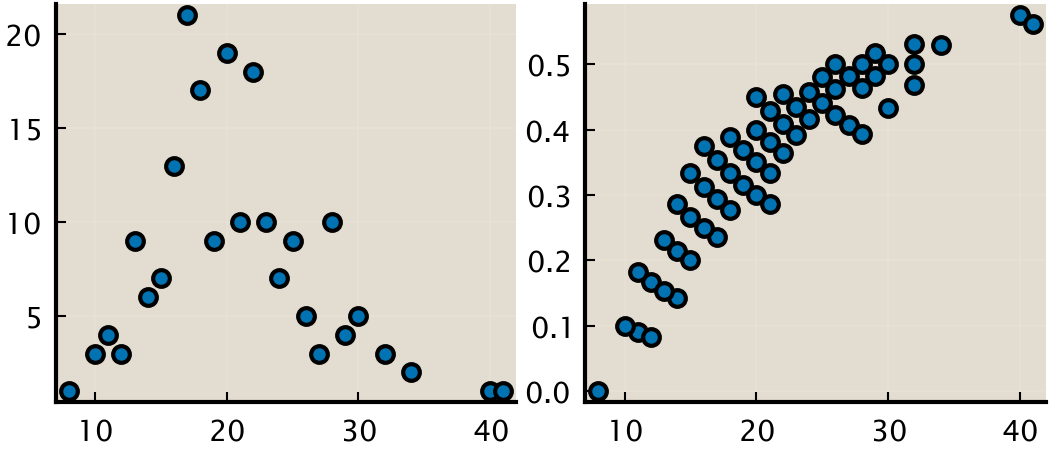

In [27]:
function show_hists(df, rho)
    gdf_l = groupby(df, [:rho, :l])
    cdf_hists_l = combine(gdf_l, nrow)
    
    gdf_gamma = groupby(df, [:rho, :Gamma, :l])
    cdf_hists_gamma = combine(gdf_gamma, nrow)
    
    return plot(
        scatter(cdf_hists_l[cdf_hists_l.rho .== rho, :l], cdf_hists_l[cdf_hists_l.rho .== rho, :nrow]),
        scatter(
            cdf_hists_gamma[cdf_hists_gamma.rho .== rho, :l], 
            cdf_hists_gamma[cdf_hists_gamma.rho .== rho, :Gamma] ./2cdf_hists_gamma[cdf_hists_gamma.rho .== rho, :l]),
        size=(350, 150)
        )
end

show_hists(df_ends, 0)


In [49]:
rho = 0
tdf = df[df.rho.==rho, :]
tdf.Gamma = tdf.Gamma./2tdf.l

default_plotlyjs!()
histogram2d(tdf.l, tdf.Gamma, nbins=15)

<!DOCTYPE html>
 
 
 Plots.jl

In [38]:
tdf.Gamma

1000-element Array{Float64,1}:
  8.0
 18.0
 28.0
 12.0
 14.0
  4.0
 36.0
 12.0
 26.0
 12.0
 30.0
 18.0
  4.0
  ⋮
 14.0
 18.0
 26.0
 34.0
 24.0
 16.0
 46.0
 28.0
 20.0
 14.0
 16.0
 18.0